# 3.02 Stable Isotope Calculation Templates - Zn isotopes
*Simon Matthews (simonm@hi.is), July 2024*

---

This notebook is intended to be a starting point for setting up calculations of stable Zn isotope fractionation during multi-component mantle melting. See other templates to set up a different set of lithologies, if you want to calculate trace elements, or to model other stable isotope systems. The methods here are generally applicable to any element whose concentrations can be calculated as a trace element during melting (e.g., U, Tl, Cu, Sr).

The calculations here are very loosely based on those in Day et al. (2022), in that they use similar parameter values, though the treatment of mantle melting here is more sophisticated.

Though I have added some description of each step, to find a more comprehensive account of why the calculation is structured the way it is see the pyMelt documentation and tutorials.

## 1. Preliminaries

Import required packages

In [1]:
import pyMelt as m
import numpy as np
import matplotlib.pyplot as plt

Retrieve a lherzolite and pyroxenite lithology. In this case, the parameterisations of KLB1 and KG1 given in Matthews et al. (2021). KLB1 represents fertile lherzolite mantle, and KG1 represents a mixture between a MORB-like eclogite composition and lherzolite. These lithologies have thermocalc phase diagrams attached.

In [2]:
lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()

Create a mantle object with 10% pyroxenite:

In [3]:
mantle = m.mantle([lz, px], [0.9, 0.1], ['lz', 'px'])

## 2. Melt the mantle

Melt the mantle assuming a $T_p$=1330˚C to produce a melting column of incremental melts.

In [4]:
column = mantle.adiabaticMelt(1330.0)

We can visualise the results of the melting calculation:

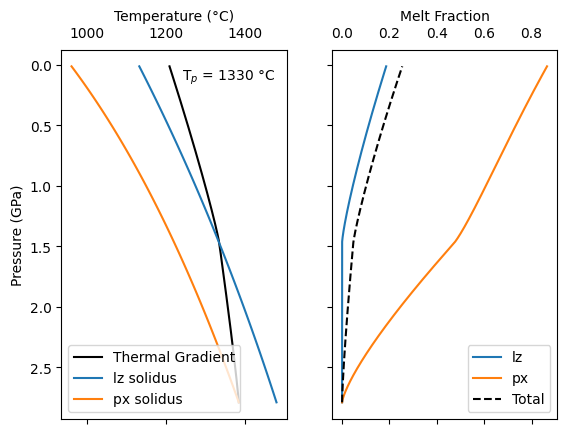

In [5]:
f, a = column.plot()

## 3. Calculate chemical properties of the melting column
First, calculate the residuum mineralogy at each step. The mineral proportions are extracted from the phase diagram attached to each lithology. This is required by the Fe-isotope calculations:

In [6]:
column.calculateMineralProportions()

We can see the results by plotting them directly:

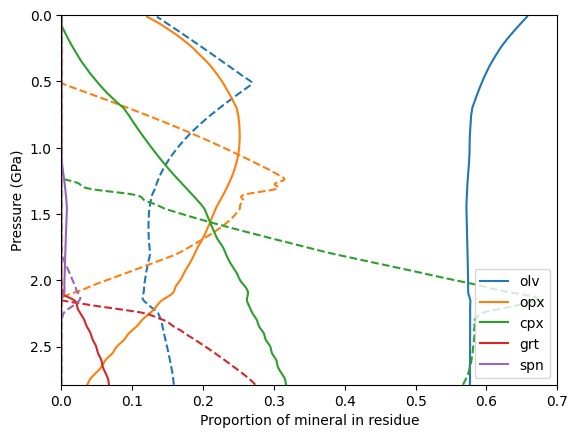

In [7]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:
    a.plot(column.composition['lz'][min], column.P, c=colours[min], label=min)
    a.plot(column.composition['px'][min], column.P, c=colours[min], ls='--')

a.legend(loc='lower right')
a.set_xlabel('Proportion of mineral in residue')
a.set_ylabel('Pressure (GPa)')

a.set_xlim(0, 0.7)
a.set_ylim(np.nanmax(column.P), 0.0)

plt.show()

The final information needed before we can calculate stable isotopes is the Zn concentration contained in the liquid and each mineral phase. We can use a trace element routine to calculate this, assuming we know something about the partitioning behaviour of Zn. Here we assume simple constant mineral-melt partition coefficients, but it is possible to implement a more sophisticated treatment (e.g., see FRTE template).

In [8]:
column.calculateTraceElements(c0={'lz': {'Zn': 65.0}, # The Zn concentration in the lherzolite component
                                  'px': {'Zn': 102.0},}, # The Zn concentration in the pyroxenite component
                              D_olv = {'Zn': 0.96},
                              D_cpx = {'Zn': 0.333},
                              D_opx = {'Zn': 0.451},
                              D_grt = {'Zn': 0.213},
                              D_spn = {'Zn': 5.2},
                              D_plg = {'Zn': 0.001},)

Again, we can visualise these results. *Note that when a phase is not present, the oxide concentration should be set to 0.0, but numerical inprecision in the phaseDiagram interpolation may make this imperfect*.

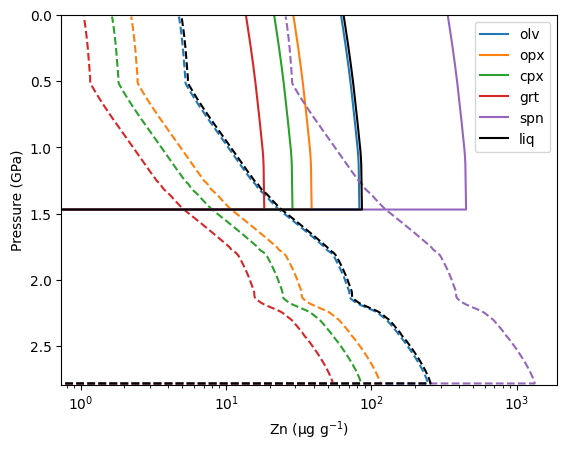

In [9]:
f, a = plt.subplots(sharey='row')

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4', 'liq': 'k'}

for min in ['olv', 'opx', 'cpx', 'grt', 'spn', 'liq']:
    a.plot(column.composition['lz'][min+'_Zn'], column.P,
              c=colours[min], label=min)
    a.plot(column.composition['px'][min+'_Zn'], column.P, 
              c=colours[min], ls='--')
    
a.set_ylim(np.nanmax(column.P), 0.0)

a.set_ylabel('Pressure (GPa)')
a.set_xlabel('Zn (µg g$^{-1}$)')

a.set_xscale('log')

a.legend()

plt.show()

All of these results are now embedded in the melting column object, and so they can now be used by the stable isotope calculations.

## 4. Set up stable isotope calculations

A mineral-melt fractionation factor must be defined for each mineral, as well as the Zn isotope ratio of the solid lithology before it melted. Since the fractionation factors depend on temperature, we can define functions for them:

In [10]:
def ff_olv(state, phaseDiagram):
    return -0.17 * 1e6 / (state['T'] + 273.15)**2

def ff_opx(state, phaseDiagram):
    return -0.17 * 1e6 / (state['T'] + 273.15)**2

def ff_cpx(state, phaseDiagram):
    return -0.17 * 1e6 / (state['T'] + 273.15)**2

def ff_grt(state, phaseDiagram):
    return -0.2 * 1e6 / (state['T'] + 273.15)**2

ff_spn = 0.0

fractionationFactors = {'olv': ff_olv, 'cpx': ff_cpx, 'opx': ff_opx, 'grt': ff_grt, 'spn': ff_spn}

## 5. Do stable isotope calculations

Now we just have to feed this information to pyMelt, along with the solid Zn isotope ratios.

In [11]:
d66Zn_lz = 0.28 # The lherzolite bulk d66Zn
d66Zn_px = 0.42 # The pyroxenite bulk d66Zn
column.calculateStableIsotopes(species='Zn',
                               fractionationFactors=fractionationFactors,
                                isotopeRatioLabel='d66Zn', # The label to be used in the results table
                                bulk={'lz': d66Zn_lz,
                                      'px': d66Zn_px},
                                fractionalExtraction= True, # Since Zn concentration was calculated assuming fractional melting
                                porosity= 0.0 # Can do continueous melting (when fractional extraction enabled) by defining a porosity
                                )

/Users/sm905/repos/pyMelt/pyMelt/meltingcolumn_classes.py:456: UserWarning: Isotope ratios for solid phases where their phase fraction goes < 0.01 are masked as a temporary fix to problematic imports.
  _warnings.warn("Isotope ratios for solid phases where their phase fraction "


And we can look at the results:

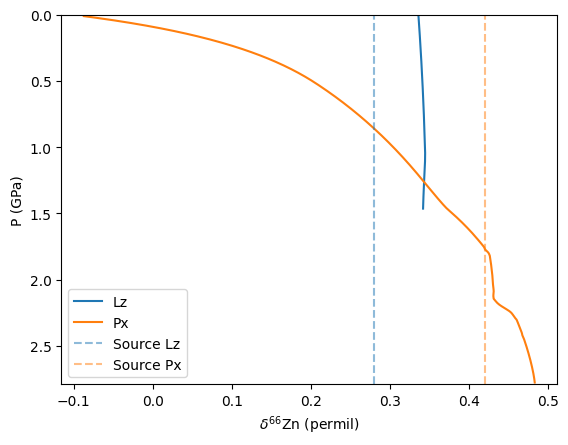

In [13]:
f, a = plt.subplots()

a.plot(column.composition['lz']['liq_d66Zn'], column.P, label='Lz')
a.plot(column.composition['px']['liq_d66Zn'], column.P, label='Px')

a.axvline(d66Zn_lz, c='C0', alpha=0.5, ls='--', label='Source Lz')
a.axvline(d66Zn_px, c='C1', alpha=0.5, ls='--', label='Source Px')


a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{66}$Zn (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='lower left')

plt.show()

We can also see how the solid residue changes in composition throughout melting:

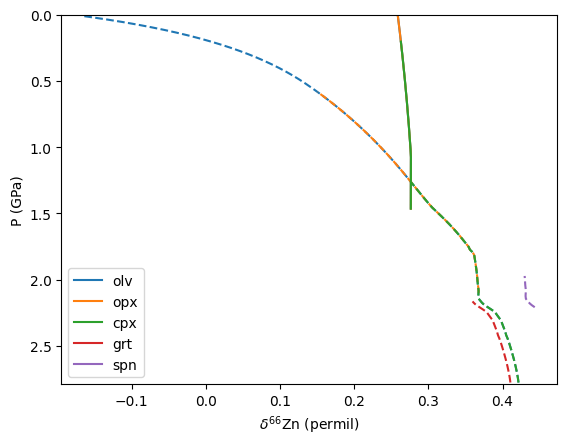

In [14]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:

    a.plot(column.composition['lz'][min+'_d66Zn'], column.P, label=min, c=colours[min])
    a.plot(column.composition['px'][min+'_d66Zn'], column.P, ls='--', c=colours[min])

a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{66}$Zn (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='lower left')

plt.show()

Since many of the minerals were set with identical mineral-melt fractionation factors this is not very exciting!

## 6. Find the aggregated melt composition
For this calculation we will assume we are at a mid-ocean ridge. See other templates for OIB melting.

We have to create a geosetting from the melting column. In doing this, pyMelt will calculate the crustal thickness (and therefore the depth at which melting should terminate) as well as calculating the weighting for each melt batch, assuming a triangular melting region.

In [15]:
mor = m.geosettings.spreadingCentre(column)

/Users/sm905/repos/pyMelt/pyMelt/geosettings.py:480: RuntimeWarning: invalid value encountered in scalar divide
  rnormed[i + 1] = (_np.sum(r[1:i + 1] * c[1:i + 1] * df[:i]) / _np.sum(df[:i] * c[1:i + 1]))


Find the aggregated $\delta^{66}$Zn:

In [16]:
mor.chemistry.liq_d66Zn

nan

## References
Day, J. M. D., Moynier, F., & Ishizuka, O. (2022). A partial melting control on the Zn isotope composition of basalts. Geochemical Perspectives Letters, 23, 11-16. https://doi.org/10.7185/geochemlet.2230